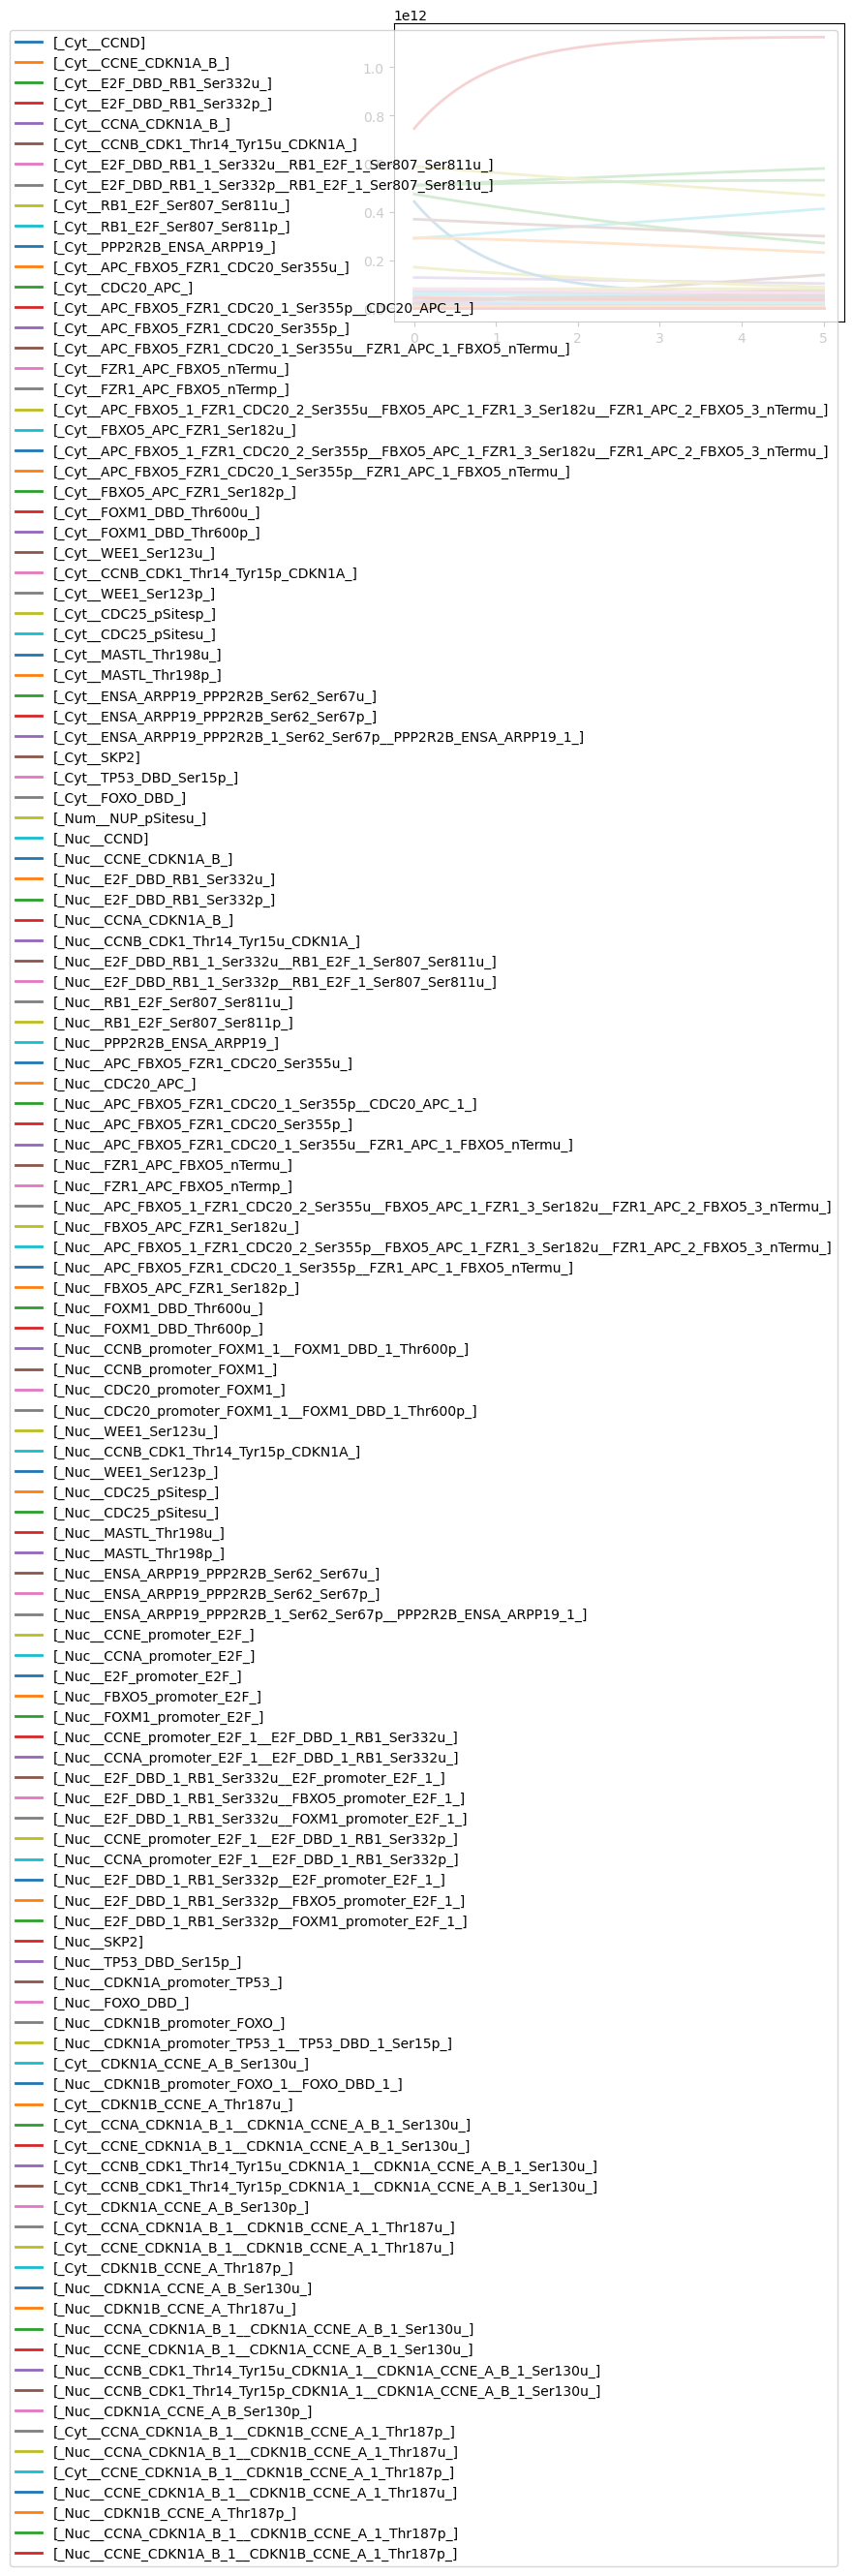

In [23]:
import tellurium as te
import time
import numpy as np
import matplotlib.pyplot as plt

model=te.loadSBMLModel("sbml_models/v4.0.0_optimized.xml")
a=time.time()
sol=model.simulate(0,5,200)
# b=time.time()
# print(b-a)


model.plot()





In [18]:
model.getFullStoichiometryMatrix(
    
)

     R_expression, R_degradation, R_L_binding, C_degradation, C_I_binding, I_activation, X_degradation, A_degradation, I_expression, I_degradation
R [[            1,            -1,          -1,             0,           0,            0,             0,             0,            0,             0],
C  [            0,             0,           1,            -1,          -1,            1,             0,             0,            0,             0],
I  [            0,             0,           0,             0,          -1,            0,             0,             0,            1,            -1],
X  [            0,             0,           0,             0,           1,           -1,            -1,             0,            0,             0],
A  [            0,             0,           0,             0,           0,            1,             0,            -1,            0,             0]]

my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

In [5]:
my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

{'key1': 'value1', 'key2': 'value2'}


In [16]:
%timeit model.simulate(0,10,100)

48.2 µs ± 531 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
